In [1]:
import os 
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# About

__Author:__ Pat McCornack

__Date:__ 02/14/25

__Description:__  
This notebook preprocesses the data and does basic qc checks. This includes subsetting the variables, renaming the variables to a standard format, and taking the action specified in the finding summary. 

__Findings Summary:__  

__Outputs:__  
Cleaned data is output to `./data/02-clean/`

## Data QC 

In [2]:
#### Specify Arguments ###
fname1 = 'sci-cair.csv'
fname2 = 'sci-caircsun.csv'

root_dir = Path().resolve().parents[1]
data_dir = root_dir / 'data'
src_fpath1 = data_dir / '01-raw' / 'met-station' / fname1
src_fpath2 = data_dir / '01-raw' / 'met-station' / fname2

outfpath = data_dir / '02-clean' / f'{str(fname1).split('.')[0]}-clean.csv'

# Define variables
var_dict = {
    'time (PST)' : 'datetime',
    'fog' : 'Fog',
    'air temperature (C)' : 'Temp',
    'relative humidity (%)' : 'RH',
    'wind speed (m/s)' : 'WindSpd',
    'wind gust (m/s)' : 'WdSpdms_MAX',
    'wind direction (deg)' : 'WindDir',
    'rain (mm)' : 'Rain',
    'leaf wetness' : 'LeafWet',  # Unsure what the units are on this
    'soil moisture' : 'SoilMoist'  # I think this is VWC
}

# Fog tip value
fog_tip_v = 0.2

In [17]:
#### Read in and prepare data ####
df1 = pd.read_csv(src_fpath1)
df2 = pd.read_csv(src_fpath2)

# Create timestamp
dates = [date.split(' ')[0] for date in df1['Date']]
times = [time.split(' ')[1] for time in df1['PST']]
df1['datetime'] = [date + ' ' + time for date, time in zip(dates, times)]

dates = [date.split(' ')[0] for date in df2['Date']]
times = [time.split(' ')[1] for time in df2['PST']]
df2['datetime'] = [date + ' ' + time for date, time in zip(dates, times)]

# Set the datetime index
df1['datetime'] = pd.to_datetime(df1['datetime'])
df2['datetime'] = pd.to_datetime(df2['datetime'])

df1.set_index('datetime', inplace=True)
df2.set_index('datetime', inplace=True)

# Drop Fog from caircsun - it's empty
df2.drop('Fog', axis=1, inplace=True)

# join the data
df = pd.concat([df1, df2], join='inner', axis=1).reset_index()

# Subset and rename columns
df = df[list(var_dict.values())]
df.columns = list(var_dict.keys())
df['time (PST)'] = pd.to_datetime(df['time (PST)'])

# Replace 'bad' value with NaN
df.replace(-888.888000, np.nan, inplace=True)

# Round fog values to closest .2
df['fog'] = df['fog'].round(1)

# Create fog tip var
df['fog tips'] = df['fog'] / fog_tip_v

/var/folders/77/txzkwfd92_q42s0qflv4nbh00000gn/T/ipykernel_17716/3839562039.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df1['datetime'] = pd.to_datetime(df1['datetime'])
/var/folders/77/txzkwfd92_q42s0qflv4nbh00000gn/T/ipykernel_17716/3839562039.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df2['datetime'] = pd.to_datetime(df2['datetime'])


In [18]:
df.head()

,time (PST),fog,air temperature (C),relative humidity (%),wind speed (m/s),wind gust (m/s),wind direction (deg),rain (mm),leaf wetness,soil moisture,fog tips
0,2004-04-05 15:00:00,0.0,14.73,73.300003,3.138,5.606,279.60001,0.0,2.0392,0.11574,0.0
1,2004-04-05 16:00:00,0.0,13.98,75.599998,3.123,5.958,275.89999,0.0,1.9073,0.11701,0.0
2,2004-04-05 17:00:00,0.0,12.93,78.300003,3.396,5.900,284.10001,0.0,1.6473,0.11829,0.0
3,2004-04-05 18:00:00,0.0,11.90,80.500000,3.058,5.664,283.39999,0.0,0.4498,0.11871,0.0
4,2004-04-05 19:00:00,0.0,10.96,85.400002,2.320,4.841,285.39999,0.0,0.0958,0.11914,0.0


### Missing Values
Observations:
1. Large chunks of data are missing - we won't be able to interpolate these values. 
2. Also noticed that NaN seems to be coded as -888.88
3. Wind data has same number of 'good' values as fog - it's filled with 0s during periods where data is missing for the other columns. 

Actions: 
1. Drop the missing fog observations, leave the smaller number of additional missing air temperature and relative humidity.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13893 entries, 0 to 13892
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   time (PST)             13893 non-null  datetime64[ns]
 1   fog                    13893 non-null  float64       
 2   air temperature (C)    13893 non-null  float64       
 3   relative humidity (%)  13893 non-null  float64       
 4   wind speed (m/s)       13893 non-null  float64       
 5   wind gust (m/s)        13893 non-null  float64       
 6   wind direction (deg)   13893 non-null  float64       
 7   rain (mm)              13893 non-null  float64       
 8   leaf wetness           13893 non-null  float64       
 9   soil moisture          6756 non-null   float64       
 10  fog tips               13893 non-null  float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 1.2 MB


In [14]:
df.columns

Index(['time (PST)', 'fog', 'air temperature (C)', 'relative humidity (%)',
       'wind speed (m/s)', 'wind gust (m/s)', 'wind direction (deg)',
       'rain (mm)', 'leaf wetness', 'soil moisture', 'fog tips'],
      dtype='object')

In [15]:
# Drop missing observations
df = df.dropna(subset=['air temperature (C)'])

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13893 entries, 0 to 13892
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   time (PST)             13893 non-null  datetime64[ns]
 1   fog                    13893 non-null  float64       
 2   air temperature (C)    13893 non-null  float64       
 3   relative humidity (%)  13893 non-null  float64       
 4   wind speed (m/s)       13893 non-null  float64       
 5   wind gust (m/s)        13893 non-null  float64       
 6   wind direction (deg)   13893 non-null  float64       
 7   rain (mm)              13893 non-null  float64       
 8   leaf wetness           13893 non-null  float64       
 9   soil moisture          6756 non-null   float64       
 10  fog tips               13893 non-null  float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 1.2 MB


### Univariate Distributions

Check boxplots of each variable to assess data quality. There's no major issues that are immediately apparent.  

Observations:
1. There are some RH measurements under 0% and slightly above 100. 

Actions
1. Constrain RH sensor values to 0-100. According to Gert-Jan, sensor drift like this isn't uncommon.

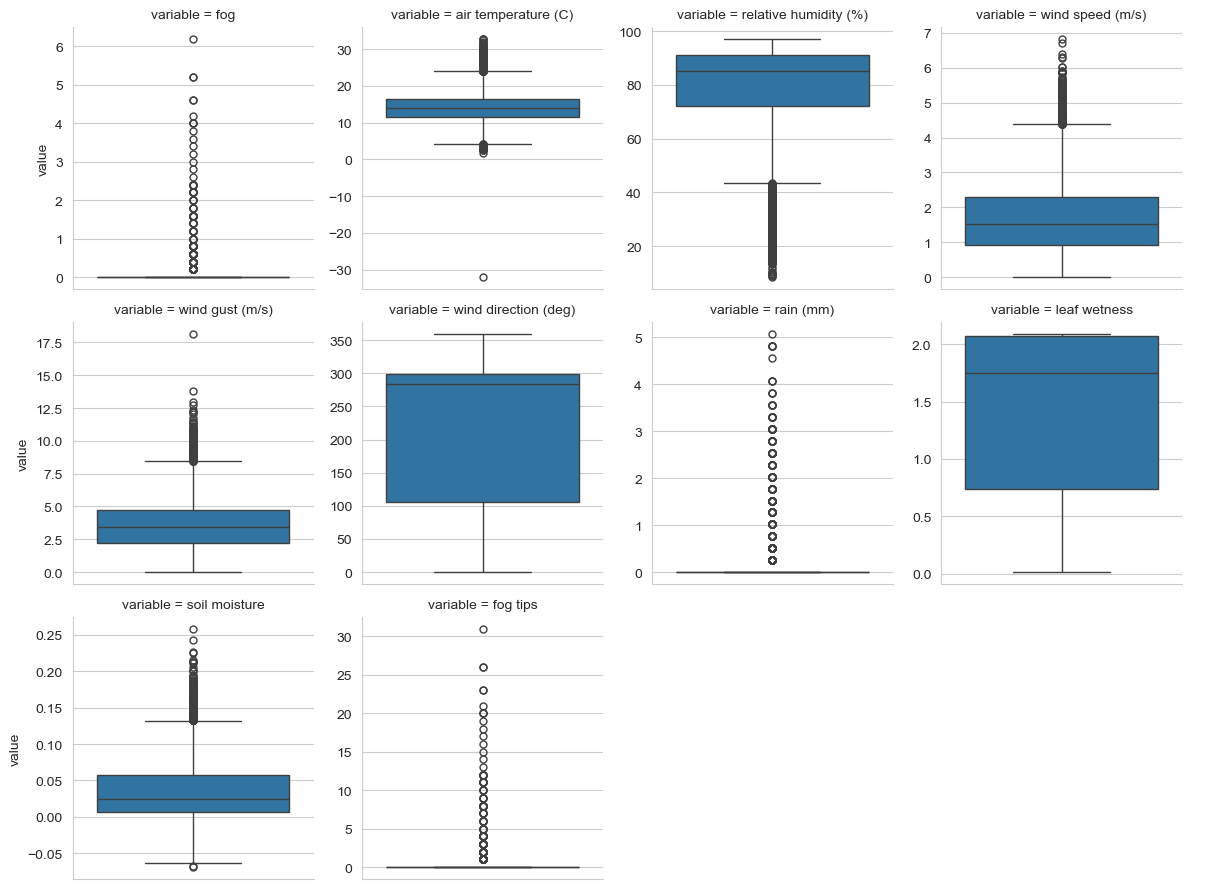

In [27]:
#### Quick plot of distributions ####
# Create long form data
value_col = df.columns.drop(['time (PST)']).tolist()
df_long = pd.melt(df, id_vars=['time (PST)'], value_vars=value_col)

# Plot boxplots
sns.catplot(data=df_long, kind='box', col='variable', y='value',
            sharey=False, height=3, col_wrap=4)
plt.show()


In [28]:
#### Chekc the actual values ####
df.describe()

,time (PST),fog,air temperature (C),relative humidity (%),wind speed (m/s),wind gust (m/s),wind direction (deg),rain (mm),leaf wetness,soil moisture,fog tips
count,13893,13893.000000,13893.000000,13893.000000,13893.000000,13893.000000,13893.000000,13893.000000,13893.000000,6756.000000,13893.000000
mean,2005-01-20 01:00:00,0.015778,14.094871,80.257528,1.687279,3.675281,227.937923,0.039637,1.410112,0.039774,0.078889
min,2004-04-05 15:00:00,0.000000,-32.000000,8.510000,0.000000,0.000000,0.000000,0.000000,0.012800,-0.068780,0.000000
25%,2004-08-28 08:00:00,0.000000,11.610000,72.199997,0.920000,2.254000,106.200000,0.000000,0.740400,0.007150,0.000000
50%,2005-01-20 01:00:00,0.000000,13.970000,85.000000,1.508000,3.430000,284.299990,0.000000,1.746200,0.024120,0.000000
75%,2005-06-13 18:00:00,0.000000,16.559999,91.300003,2.305000,4.743000,298.299990,0.000000,2.074600,0.057200,0.000000
max,2005-11-05 11:00:00,6.200000,32.840000,97.199997,6.833000,18.170000,359.899990,5.080000,2.091700,0.258270,31.000000
std,NaN,0.181664,4.100959,14.549684,1.004055,1.799617,93.165630,0.272997,0.725377,0.046408,0.908320


### Constrain RH
Ensure all values are between 0 and 100

In [29]:
df['relative humidity (%)'] = df['relative humidity (%)'].clip(lower=0, upper=100)

### Remove air temperature outlier
A value of -32C at this site isnt' possible, remove that observation

In [30]:
df = df.loc[df['air temperature (C)'] != -32]

### Check leaf wetness values - is there a clear response to moisture? 
The pattern is odd, or now I'm not going to include LW in the output. 

<Axes: xlabel='condition', ylabel='leaf wetness'>

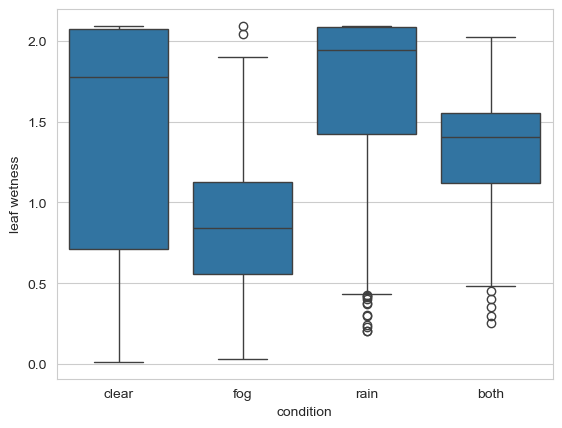

In [31]:
def label_condition(df):
    df['condition'] = 'clear'
    for index, row in df.iterrows():
        condition='clear'
        if row['fog tips'] > 0:
            df.loc[index, 'condition'] = 'fog'

        if row['rain (mm)'] > 0:
            df.loc[index, 'condition'] = 'rain'
        
        if (row['rain (mm)'] > 0) & (row['fog tips'] > 0):
            df.loc[index, 'condition'] = 'both'
    
    return df
tmp = df[['fog tips', 'rain (mm)', 'leaf wetness']].copy()
tmp = label_condition(tmp)

sns.boxplot(data=tmp,
            x='condition',
            y='leaf wetness')

### Fog Check
Given the focus of further analysis on fog at the site, further check the distribution of fog.


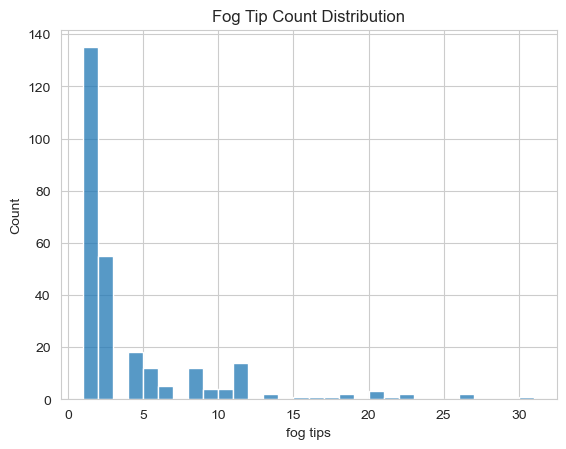

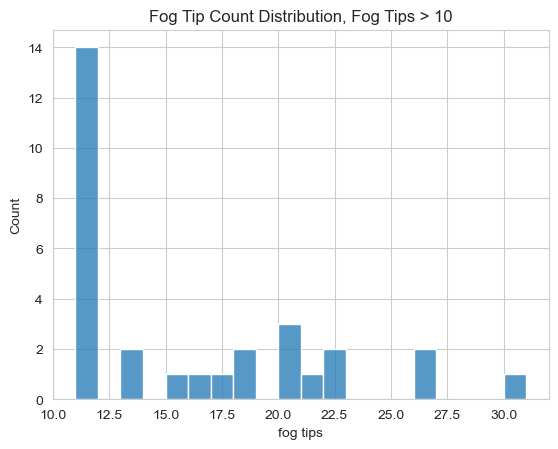

In [32]:
#### Check Distribution of Fog Values ####
sns.histplot(df['fog tips'].loc[df['fog tips']>0],
             binwidth=1)
plt.title('Fog Tip Count Distribution')
plt.show()

# Check right tail of distribution
sns.histplot(df['fog tips'].loc[df['fog tips']>10],
             binwidth=1)
plt.title('Fog Tip Count Distribution, Fog Tips > 10')
plt.show()

In [33]:
df.head()

,time (PST),fog,air temperature (C),relative humidity (%),wind speed (m/s),wind gust (m/s),wind direction (deg),rain (mm),leaf wetness,soil moisture,fog tips
0,2004-04-05 15:00:00,0.0,14.73,73.300003,3.138,5.606,279.60001,0.0,2.0392,0.11574,0.0
1,2004-04-05 16:00:00,0.0,13.98,75.599998,3.123,5.958,275.89999,0.0,1.9073,0.11701,0.0
2,2004-04-05 17:00:00,0.0,12.93,78.300003,3.396,5.900,284.10001,0.0,1.6473,0.11829,0.0
3,2004-04-05 18:00:00,0.0,11.90,80.500000,3.058,5.664,283.39999,0.0,0.4498,0.11871,0.0
4,2004-04-05 19:00:00,0.0,10.96,85.400002,2.320,4.841,285.39999,0.0,0.0958,0.11914,0.0


### Save out cleaned data

In [34]:
#### Save out cleaned data ####
df.to_csv(outfpath)
print(outfpath)

/Users/patmccornack/Documents/ucsb_fog_project/_repositories/sci-fog-analysis/data/02-clean/sci-cair-clean.csv
